# Objectives

# Section 1 - Loading and Preprocess the data

## 1.1: Preprocess each CSV file 

In [341]:
import pandas as pd
from prettypandas import PrettyPandas
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess Trade Indicators - FAOSTAT_data_en_2-22-2024.csv file

In [342]:
import pandas as pd
from prettypandas import PrettyPandas

# Load the dataset
df_trade = pd.read_csv('./Food trade indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns and rename them
df_trade = df_trade[['Area', 'Item', 'Year', 'Element', 'Value']]

# Drop rows with any empty values
df_trade = df_trade.dropna()

# Drop rows with 'Item' = 'Meat and Meat Preparations' and 'Dairy Products and Eggs'
# df_trade = df_trade.loc[~df_trade['Item'].isin(['Meat and Meat Preparations', 'Dairy Products and Eggs'])]

# only keep rows with 'Item' = 'Fruit and Vegetables'
df_trade = df_trade.loc[df_trade['Item'] == 'Fruit and Vegetables']

# Pivot the table for 'Import Value' and 'Export Value'
df_import = df_trade[df_trade['Element'] == 'Import Value'].pivot_table(
    index=['Area', 'Item', 'Year'],
    values='Value',
    aggfunc='first'
).rename(columns={'Value': 'Import_Value'}).reset_index()

df_export = df_trade[df_trade['Element'] == 'Export Value'].pivot_table(
    index=['Area', 'Item', 'Year'],
    values='Value',
    aggfunc='first'
).rename(columns={'Value': 'Export_Value'}).reset_index()

# Merge the pivoted DataFrames on 'Area', 'Item', and 'Year'
df_trade_values = pd.merge(df_import, df_export, on=['Area', 'Item', 'Year'], how='inner')

# Create a new column for 'Year' 3 years ahead
df_trade_values['Year_3_Ahead'] = df_trade_values['Year'] + 3

# Merge with itself to get export value 3 years ahead
df_trade_values = pd.merge(df_trade_values, df_trade_values[['Area', 'Item', 'Year', 'Export_Value']],
                           left_on=['Area', 'Item', 'Year_3_Ahead'], right_on=['Area', 'Item', 'Year'],
                           suffixes=('', '_3_Years_Ahead'), how='left')

# Sort by 'Area', 'Item', 'Year' to ensure chronological order for lag and rolling calculations
df_trade_values.sort_values(by=['Area', 'Item', 'Year'], inplace=True)

# Function to create lag and rolling window features within each group
def create_features(group):
    # Create lag features for 'Export_Value'
    group['Export_Value_Lag1'] = group['Export_Value'].shift(1)
    group['Export_Value_Lag2'] = group['Export_Value'].shift(2)
    group['Export_Value_Lag3'] = group['Export_Value'].shift(3)

    # Create a 3-year rolling mean for 'Export_Value'
    group['Export_Value_Rolling_Mean3'] = group['Export_Value'].rolling(window=3).mean()

    return group

# Apply the function to each group
df_trade_values = df_trade_values.groupby(['Area', 'Item']).apply(create_features)

# Drop rows with any NaN values created by the lag and rolling operations
df_trade_values.dropna(inplace=True)

# Drop unnecessary columns
df_trade_values.drop(['Year_3_Ahead', 'Year_3_Years_Ahead'], axis=1, inplace=True)

#save the data
df_trade_values.to_csv('trade_values.csv', index=False)


/var/folders/05/bhm59zj95991r59cy3wkr47h0000gn/T/ipykernel_70833/2424896451.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_trade_values = df_trade_values.groupby(['Area', 'Item']).apply(create_features)


### Preprocess Pesticides use - FAOSTAT_data_en_2-27-2024.csv file

In [343]:
# Load the pesticides data
df_pesticides = pd.read_csv('./Pesticides use - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_pesticides = df_pesticides[['Area', 'Item', 'Year', 'Element', 'Value']]

# Drop rows with any empty values
df_pesticides = df_pesticides.dropna()

# Pivot the table
df_pesticides_pivot = df_pesticides.pivot_table(
    index=['Area', 'Year'],
    columns=['Item', 'Element'],
    values='Value',
    aggfunc='first'
).reset_index()

# Flatten the MultiIndex in columns and create meaningful column names
df_pesticides_pivot.columns = ['_'.join(col).strip() for col in df_pesticides_pivot.columns.values]
df_pesticides_pivot = df_pesticides_pivot.rename(columns={'Area_': 'Area', 'Year_': 'Year'})

# Add 'Pesticide_' prefix
df_pesticides_pivot = df_pesticides_pivot.rename(columns=lambda x: f'Pesticide_{x}' if x not in ['Area', 'Year'] else x)

# # Fill missing values with 0 assuming no pesticides of that type were used
# df_pesticides_pivot = df_pesticides_pivot.fillna(0)

PrettyPandas(df_pesticides_pivot.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,Pesticide_Fungicides and Bactericides_Agricultural Use,Pesticide_Fungicides – Seed treatments_Agricultural Use,Pesticide_Herbicides_Agricultural Use,Pesticide_Insecticides_Agricultural Use,Pesticide_Insecticides – Seed Treatments_Agricultural Use,Pesticide_Pesticides (total)_Agricultural Use,Pesticide_Pesticides (total)_Use per area of cropland,Pesticide_Pesticides (total)_Use per value of agricultural production,Pesticide_Rodenticides_Agricultural Use
0,Albania,2000,105.730000,0.050000,7.990000,169.600000,9.010000,307.980000,0.440000,0.230000,7.540000
1,Albania,2001,108.080000,0.060000,7.990000,174.520000,10.810000,319.380000,0.460000,0.230000,8.250000
2,Albania,2002,110.430000,0.070000,7.980000,179.440000,12.610000,330.780000,0.470000,0.240000,8.960000
3,Albania,2003,112.770000,0.080000,7.980000,184.360000,14.410000,342.170000,0.490000,0.240000,9.670000
4,Albania,2004,115.120000,0.090000,7.980000,189.280000,16.210000,353.570000,0.510000,0.230000,10.370000


### Preprocess Land use - FAOSTAT_data_en_2-22-2024.csv file

In [344]:
# Load the dataset
df_land_use = pd.read_csv('./Land use - FAOSTAT_data_en_2-22-2024.csv', low_memory=False)

# Select the columns
df_land_use = df_land_use[['Area', 'Year', 'Item', 'Value']]

# Drop rows with 'Item' = 'Country are' and 'Land area'
df_land_use = df_land_use.loc[~df_land_use['Item'].isin(['Country area', 'Land area', 'Agricultural land'])]

# Drop rows with any empty values
df_land_use = df_land_use.dropna()

# Pivot the table to have one row per 'Area' and 'Year' and each 'Item' as a column
df_land_use_pivot = df_land_use.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value'
).reset_index()

# Rename the pivoted columns for clarity, appending 'LandUse_' to each
df_land_use_pivot.columns = ['Area', 'Year'] + [f'LandUse_{col}' for col in df_land_use_pivot.columns[2:]]

PrettyPandas(df_land_use_pivot.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,LandUse_Agriculture,LandUse_Agriculture area actually irrigated,LandUse_Arable land,LandUse_Cropland,LandUse_Cropland area actually irrigated,LandUse_Farm buildings and Farmyards,LandUse_Forestry area actually irrigated,LandUse_Land area actually irrigated,LandUse_Land area equipped for irrigation,LandUse_Perm. meadows & pastures - Cultivated,LandUse_Perm. meadows & pastures - Nat. growing,LandUse_Perm. meadows & pastures area actually irrig.,LandUse_Permanent crops,LandUse_Permanent meadows and pastures,LandUse_Temporary crops,LandUse_Temporary fallow,LandUse_Temporary meadows and pastures
0,Afghanistan,1980,38049.000000,nan,7910.000000,8049.000000,nan,nan,nan,nan,2505.000000,nan,nan,nan,139.000000,30000.000000,nan,nan,nan
1,Afghanistan,1981,38053.000000,nan,7910.000000,8053.000000,nan,nan,nan,nan,2520.000000,nan,nan,nan,143.000000,30000.000000,nan,nan,nan
2,Afghanistan,1982,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2535.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan
3,Afghanistan,1983,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2550.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan
4,Afghanistan,1984,38054.000000,nan,7910.000000,8054.000000,nan,nan,nan,nan,2581.000000,nan,nan,nan,144.000000,30000.000000,nan,nan,nan


### Preprocess Land temperature change - FAOSTAT_data_en_2-27-2024.csv

In [345]:
# Load the dataset
df_temperature = pd.read_csv('./Land temperature change - FAOSTAT_data_en_2-27-2024.csv')

# Filter for 'Temperature change' during the 'Meteorological year'
df_temperature_annual = df_temperature[
    (df_temperature['Element'] == 'Temperature change') &
    (df_temperature['Months'] == 'Meteorological year')
]

# Select relevant columns
df_temperature_annual = df_temperature_annual[['Area', 'Year', 'Value']]

# Rename the 'Value' column to 'TempChange_Annual'
df_temperature_annual.rename(columns={'Value': 'TempChange_Annual'}, inplace=True)

# Fill missing value for Area = 'Rwanda' with value from 'Burundi' for the same year
df_temperature_annual.loc[df_temperature_annual['Area'] == 'Rwanda', 'TempChange_Annual'] = \
    df_temperature_annual.loc[df_temperature_annual['Area'] == 'Uganda', 'TempChange_Annual'].values

PrettyPandas(df_temperature_annual.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,TempChange_Annual
184,Afghanistan,2000,0.993000
185,Afghanistan,2001,1.311000
186,Afghanistan,2002,1.365000
187,Afghanistan,2003,0.587000
188,Afghanistan,2004,1.373000


### Preprocess Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv

In [346]:
# Load the dataset
df_fdi = pd.read_csv('./Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv')

# Select relevant columns
df_fdi_relevant = df_fdi[['Area', 'Year', 'Item', 'Value']]

# Use FDI inflows to agriculture only
df_fdi_agri = df_fdi_relevant[df_fdi_relevant['Item'].str.contains('FDI inflows to Agriculture, Forestry and Fishing')]

# Pivot the table
df_fdi_pivot = df_fdi_agri.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value'
).reset_index()

# Rename the columns
df_fdi_pivot.rename(columns=lambda x: f'{x.replace(", ", "_").replace(" ", "_")}' if x not in ['Area', 'Year'] else x, inplace=True)

PrettyPandas(df_fdi_pivot.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Item,Area,Year,FDI_inflows_to_Agriculture_Forestry_and_Fishing
0,Albania,2004,0.642888
1,Albania,2005,0.494601
2,Albania,2006,2.508966
3,Albania,2007,2.737334
4,Albania,2008,-79.100597


### Preprocess Food security indicators  - FAOSTAT_data_en_2-22-2024.csv

In [347]:
# Load the dataset
df_food_security = pd.read_csv('./Food security indicators  - FAOSTAT_data_en_2-22-2024.csv')

# Filter for relevant 'Item' categories based on the focus of the analysis and create a copy to avoid SettingWithCopyWarning
irrelevant_items = [
    'Prevalence of anemia among women of reproductive age (15-49 years)',
    'Prevalence of low birthweight (percent)',
    'Per capita food production variability (constant 2014-2016 thousand int$ per capita)',
    'Percent of arable land equipped for irrigation (percent) (3-year average)'
]

#drop FSI_Prevalence_of_anemia_among_women_of_reproductive_age_15_49_years and FSI_Prevalence_of_low_birthweight_percent
df_food_security_relevant = df_food_security[~df_food_security['Item'].isin(irrelevant_items)].copy()
    

# Convert 'Year' to a string to handle both single years and ranges (e.g., '2000-2002')
df_food_security_relevant['Year'] = df_food_security_relevant['Year'].astype(str)

# Split into yearly and 3-year average DataFrames
df_yearly = df_food_security_relevant[~df_food_security_relevant['Year'].str.contains('-')]
df_3year_avg = df_food_security_relevant[df_food_security_relevant['Year'].str.contains('-')]

# Expand 3-year averages into annual values
expanded_rows = []
for _, row in df_3year_avg.iterrows():
    start_year, end_year = map(int, row['Year'].split('-'))
    for year in range(start_year, end_year + 1):
        new_row = row.copy()
        new_row['Year'] = str(year)
        expanded_rows.append(new_row)

df_expanded = pd.DataFrame(expanded_rows)

# Merge expanded 3-year data with yearly data, giving precedence to yearly data
df_combined = pd.concat([df_yearly, df_expanded]).drop_duplicates(subset=['Area', 'Year', 'Item'], keep='first')

# Pivot the combined table to get one row per 'Area' and 'Year', with separate columns for each indicator
df_fsi_combined_pivot = df_combined.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns for clarity, adding 'FSI_' prefix for Food Security Indicator
df_fsi_combined_pivot.columns = ['Area', 'Year'] + [f'FSI_{c.replace(", ", "_").replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")}' for c in df_fsi_combined_pivot.columns[2:]]

PrettyPandas(df_fsi_combined_pivot.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,FSI_Average_dietary_energy_supply_adequacy_percent_3_year_average,FSI_Average_protein_supply_g/cap/day_3_year_average,FSI_Cereal_import_dependency_ratio_percent_3_year_average,FSI_Per_capita_food_supply_variability_kcal/cap/day,FSI_Political_stability_and_absence_of_violence/terrorism_index,FSI_Value_of_food_imports_in_total_merchandise_exports_percent_3_year_average
0,Afghanistan,2000,88.000000,51.400000,34.100000,58.000000,-2.440000,240.000000
1,Afghanistan,2001,88.000000,51.400000,34.100000,47.000000,nan,240.000000
2,Afghanistan,2002,88.000000,51.400000,34.100000,71.000000,-2.040000,240.000000
3,Afghanistan,2003,89.000000,52.100000,29.300000,72.000000,-2.200000,281.000000
4,Afghanistan,2004,92.000000,54.000000,21.100000,50.000000,-2.300000,199.000000


### Preprocess Food balances indicators - FAOSTAT_data_en_2-22-2024.csv

In [348]:
# Load the dataset
df_food_balances = pd.read_csv('./Food balances indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select columns
df_food_balances_relevant = df_food_balances[['Area', 'Year', 'Element', 'Item', 'Value']]

# Drop rows with Item = Meat, Eggs, Milk - Excluding Butter, Fish, Seafood
df_food_balances_relevant = df_food_balances_relevant.loc[~df_food_balances_relevant['Item'].isin(['Meat', 'Eggs', 'Milk - Excluding Butter', 'Fish, Seafood'])]

# only keep elements 'export quantity'
df_food_balances_relevant = df_food_balances_relevant.loc[df_food_balances_relevant['Element'] == 'Export Quantity']

# Create a new column 'Element_Item' combining 'Element' and 'Item'
df_food_balances_relevant['Element_Item'] = df_food_balances_relevant['Element'] + '_' + df_food_balances_relevant['Item']

# Pivot the table
df_food_balances_pivot = df_food_balances_relevant.pivot_table(
    index=['Area', 'Year'],
    columns='Element_Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns
df_food_balances_pivot.rename(columns=lambda x: f'FoodBalance_{x.replace(" ", "_").replace(",", "_").replace("-", "_").replace("/", "_")}' if x not in ['Area', 'Year'] else x, inplace=True)

# # Fill missing values with 0 assuming no food of that type was produced
# df_food_balances_pivot = df_food_balances_pivot.fillna(0)

PrettyPandas(df_food_balances_pivot.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Element_Item,Area,Year,FoodBalance_Export_Quantity_Alcoholic_Beverages,FoodBalance_Export_Quantity_Cereals___Excluding_Beer,FoodBalance_Export_Quantity_Fruits___Excluding_Wine,FoodBalance_Export_Quantity_Oilcrops,FoodBalance_Export_Quantity_Pulses,FoodBalance_Export_Quantity_Spices,FoodBalance_Export_Quantity_Starchy_Roots,FoodBalance_Export_Quantity_Stimulants,FoodBalance_Export_Quantity_Sugar_&_Sweeteners,FoodBalance_Export_Quantity_Sugar_Crops,FoodBalance_Export_Quantity_Treenuts,FoodBalance_Export_Quantity_Vegetable_Oils,FoodBalance_Export_Quantity_Vegetables
0,Afghanistan,2010,nan,0.000000,158.000000,15.000000,1.000000,6.000000,26.000000,nan,0.000000,nan,5.000000,nan,149.000000
1,Afghanistan,2011,nan,0.000000,173.000000,11.000000,0.000000,4.000000,9.000000,nan,0.000000,nan,7.000000,nan,73.000000
2,Afghanistan,2012,nan,0.000000,142.000000,12.000000,0.000000,3.000000,4.000000,nan,0.000000,nan,9.000000,nan,28.000000
3,Afghanistan,2013,nan,0.000000,175.000000,11.000000,0.000000,5.000000,41.000000,nan,0.000000,nan,12.000000,nan,37.000000
4,Afghanistan,2014,0.000000,2.000000,252.000000,18.000000,29.000000,21.000000,7.000000,0.000000,1.000000,nan,12.000000,1.000000,69.000000


### Preprocess Fertilizers use - FAOSTAT_data_en_2-27-2024.csv

In [349]:
# Load the dataset
df_fertilizers = pd.read_csv('./Fertilizers use - FAOSTAT_data_en_2-27-2024.csv')

# Select the columns
df_fertilizers_relevant = df_fertilizers[['Area', 'Year', 'Item', 'Value']]

# Pivot the table
df_fertilizers_pivot = df_fertilizers_relevant.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Rename the columns
df_fertilizers_pivot.rename(columns=lambda x: f'FertilizerUse_{x.replace(" ", "_").replace(",", "_").replace("-", "_").replace("(", "").replace(")", "")}' if x not in ['Area', 'Year'] else x, inplace=True)

# # Fill missing values with 0 assuming no fertilizers of that type were used
# df_fertilizers_pivot = df_fertilizers_pivot.fillna(0)

PrettyPandas(df_fertilizers_pivot.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Item,Area,Year,FertilizerUse_Ammonia__anhydrous,FertilizerUse_Ammonium_nitrate_AN,FertilizerUse_Ammonium_sulphate,FertilizerUse_Calcium_ammonium_nitrate_CAN_and_other_mixtures_with_calcium_carbonate,FertilizerUse_Diammonium_phosphate_DAP,FertilizerUse_Fertilizers_n.e.c.,FertilizerUse_Monoammonium_phosphate_MAP,FertilizerUse_NPK_fertilizers,FertilizerUse_Other_NK_compounds,FertilizerUse_Other_NP_compounds,FertilizerUse_Other_nitrogenous_fertilizers__n.e.c.,FertilizerUse_Other_phosphatic_fertilizers__n.e.c.,FertilizerUse_Other_potassic_fertilizers__n.e.c.,FertilizerUse_PK_compounds,FertilizerUse_Phosphate_rock,FertilizerUse_Potassium_chloride_muriate_of_potash_MOP,FertilizerUse_Potassium_nitrate,FertilizerUse_Potassium_sulphate_sulphate_of_potash_SOP,FertilizerUse_Sodium_nitrate,FertilizerUse_Superphosphates_above_35%,FertilizerUse_Superphosphates__other,FertilizerUse_Urea,FertilizerUse_Urea_and_ammonium_nitrate_solutions_UAN
0,Afghanistan,2002,nan,nan,nan,nan,nan,nan,nan,17900.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Afghanistan,2003,nan,nan,nan,nan,nan,nan,nan,33200.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Afghanistan,2004,nan,nan,nan,nan,nan,nan,nan,47700.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,42300.000000,nan
3,Afghanistan,2005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20577.000000,nan
4,Afghanistan,2006,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,68253.000000,nan


### Preprocess Exchange rate - FAOSTAT_data_en_2-22-2024.csv

In [350]:
# Load the dataset
df_exchange_rates = pd.read_csv('./Exchange rate - FAOSTAT_data_en_2-22-2024.csv')

# Group by 'Area' and 'Year' and calculate the mean 'Value'
df_yearly_exchange_rates = df_exchange_rates.groupby(['Area', 'Year'])['Value'].mean().reset_index()

# Rename the column
df_yearly_exchange_rates.rename(columns={'Value': 'Average_Exchange_Rate'}, inplace=True)

PrettyPandas(df_yearly_exchange_rates.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,Average_Exchange_Rate
0,Afghanistan,1980,44.129167
1,Afghanistan,1981,49.479902
2,Afghanistan,1982,50.599608
3,Afghanistan,1983,50.599608
4,Afghanistan,1984,50.599606


### Preprocess Emissions - FAOSTAT_data_en_2-27-2024.csv

In [351]:
# Load the dataset
df_emissions = pd.read_csv('./Emissions - FAOSTAT_data_en_2-27-2024.csv')

# Pivot the table
df_emissions_pivot = df_emissions.pivot_table(
    index=['Area', 'Year'],
    columns=['Element', 'Item'],
    values='Value',
    aggfunc='first'
).reset_index()

# Flatten the MultiIndex in columns and join levels with '_'
df_emissions_pivot.columns = ['_'.join(col).strip() for col in df_emissions_pivot.columns.values]

# Rename columns
df_emissions_pivot.columns = ['Area', 'Year'] + [f'Emission_{c.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")}' for c in df_emissions_pivot.columns[2:]]

PrettyPandas(df_emissions_pivot.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Area,Year,Emission_Crops_total_Emissions_CH4_All_Crops,Emission_Crops_total_Emissions_N2O_All_Crops,Emission_Emissions_CO2_Cropland_organic_soils,Emission_Emissions_CO2_Grassland_organic_soils,Emission_Emissions_N2O_Cropland_organic_soils,Emission_Emissions_N2O_Grassland_organic_soils
0,Afghanistan,2000,20.847100,0.705600,0.000000,0.000000,0.000000,0.000000
1,Afghanistan,2001,19.260500,0.705400,0.000000,0.000000,0.000000,0.000000
2,Afghanistan,2002,21.255300,1.065600,0.000000,0.000000,0.000000,0.000000
3,Afghanistan,2003,23.701700,1.311700,0.000000,0.000000,0.000000,0.000000
4,Afghanistan,2004,30.308900,1.085600,0.000000,0.000000,0.000000,0.000000


### Preprocess Crops production indicators - FAOSTAT_data_en_2-22-2024.csv

In [352]:
# Load the dataset
df_crops = pd.read_csv('./Crops production indicators - FAOSTAT_data_en_2-22-2024.csv')

# Select the columns
df_crops_filtered = df_crops[['Area', 'Year', 'Element', 'Item', 'Value']]

# Pivot the table
df_crops_pivoted = df_crops_filtered.pivot_table(index=['Area', 'Year'], columns='Item', values='Value').reset_index()

# Rename the columns
df_crops_pivoted = df_crops_pivoted.rename(columns=lambda x: 'CropYield_' + x.replace(', ', '_').replace(' ', '_').replace('(', '').replace(')', '') if x not in ['Area', 'Year'] else x)

# # Fill missing values with 0 assuming no crops of that type were produced
# df_crops_pivoted = df_crops_pivoted.fillna(0)

PrettyPandas(df_crops_pivoted.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Item,Area,Year,CropYield_Cereals_primary,CropYield_Citrus_Fruit_Total,CropYield_Fibre_Crops_Fibre_Equivalent,CropYield_Fruit_Primary,CropYield_Oilcrops_Cake_Equivalent,CropYield_Oilcrops_Oil_Equivalent,CropYield_Pulses_Total,CropYield_Roots_and_Tubers_Total,CropYield_Sugar_Crops_Primary,CropYield_Treenuts_Total,CropYield_Vegetables_Primary
0,Afghanistan,2000,8063.000000,71245.000000,3990.000000,76730.000000,3833.000000,2231.000000,10203.000000,167857.000000,177273.000000,16378.000000,124154.000000
1,Afghanistan,2001,10067.000000,71417.000000,3990.000000,80268.000000,3829.000000,2217.000000,10262.000000,167857.000000,177273.000000,16190.000000,124344.000000
2,Afghanistan,2002,16698.000000,71477.000000,3990.000000,80174.000000,3818.000000,2202.000000,10317.000000,164286.000000,177273.000000,18370.000000,123884.000000
3,Afghanistan,2003,14580.000000,73423.000000,3850.000000,82792.000000,3844.000000,2532.000000,10712.000000,166667.000000,174286.000000,16328.000000,124287.000000
4,Afghanistan,2004,13348.000000,78025.000000,3843.000000,79157.000000,3951.000000,2716.000000,10769.000000,176471.000000,162500.000000,12909.000000,132255.000000


### Preprocess Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv

In [353]:
# Load the dataset
df_consumer_prices = pd.read_csv('./Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv')

# Pivot the table
df_consumer_prices_pivot = df_consumer_prices.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='mean'  # Use mean to aggregate monthly data into a single annual value
).reset_index()

# Rename the columns
df_consumer_prices_pivot.rename(columns={
    'Consumer Prices, Food Indices (2015 = 100)': 'ConsumerPrice_Food_Indices',
    'Food price inflation': 'ConsumerPrice_Food_Price_Inflation'
}, inplace=True)

PrettyPandas(df_consumer_prices_pivot.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Item,Area,Year,ConsumerPrice_Food_Indices,ConsumerPrice_Food_Price_Inflation
0,Afghanistan,2000,26.629848,nan
1,Afghanistan,2001,29.893548,12.780692
2,Afghanistan,2002,35.344892,18.254516
3,Afghanistan,2003,40.203113,14.102244
4,Afghanistan,2004,45.840561,14.072172


### Preprocess Employment - FAOSTAT_data_en_2-27-2024.csv

In [354]:
# Load the dataset
df_employment = pd.read_csv('./Employment - FAOSTAT_data_en_2-27-2024.csv')

# Pivot the table
df_employment_pivot = df_employment.pivot_table(
    index=['Area', 'Year'],
    columns='Indicator',
    values='Value',
    aggfunc='first'  # Assuming there's only one value per area-year-indicator combination
).reset_index()

# Rename columns for clarity and ensure compatibility for merging
df_employment_pivot.rename(columns={
    'Mean weekly hours actually worked per employed person in agriculture, forestry and fishing': 'Employment_Agriculture_Work_Hours_Per_Week',
    'Employment in agriculture, forestry and fishing - ILO modelled estimates': 'Employment_Agriculture_Estimates'
}, inplace=True)

# # Fill missing values with mean of that specific area
# df_employment_pivot = df_employment_pivot.fillna(df_employment_pivot.groupby('Area').transform('mean'))

# # If there are still missing values, fill them with the mean of the entire column since work hours are similar across countries
# df_employment_pivot['Employment_Agriculture_Work_Hours_Per_Week'] = df_employment_pivot['Employment_Agriculture_Work_Hours_Per_Week'].fillna(df_employment_pivot['Employment_Agriculture_Work_Hours_Per_Week'].mean())

PrettyPandas(df_employment_pivot.head())


/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


Indicator,Area,Year,Employment_Agriculture_Estimates,Employment_Agriculture_Work_Hours_Per_Week
0,Afghanistan,2000,2765.950000,nan
1,Afghanistan,2001,2805.540000,nan
2,Afghanistan,2002,2897.510000,nan
3,Afghanistan,2003,3093.270000,nan
4,Afghanistan,2004,3212.460000,nan


## 1.2: Perform Merging of DataFrames

In [355]:
# Ensure 'Area' and 'Year' are not part of the index in all DataFrames before merging
df_trade_values = df_trade_values.reset_index(drop=True)

# Ensure 'Area' is string type and 'Year' is string type in all DataFrames
df_trade_values['Area'] = df_trade_values['Area'].astype(str)
df_trade_values['Year'] = df_trade_values['Year'].astype(str)

df_pesticides_pivot['Area'] = df_pesticides_pivot['Area'].astype(str)
df_pesticides_pivot['Year'] = df_pesticides_pivot['Year'].astype(str)

df_land_use_pivot['Area'] = df_land_use_pivot['Area'].astype(str)
df_land_use_pivot['Year'] = df_land_use_pivot['Year'].astype(str)

df_temperature_annual['Area'] = df_temperature_annual['Area'].astype(str)
df_temperature_annual['Year'] = df_temperature_annual['Year'].astype(str)

df_fdi_pivot['Area'] = df_fdi_pivot['Area'].astype(str)
df_fdi_pivot['Year'] = df_fdi_pivot['Year'].astype(str)

df_fsi_combined_pivot['Area'] = df_fsi_combined_pivot['Area'].astype(str)
df_fsi_combined_pivot['Year'] = df_fsi_combined_pivot['Year'].astype(str)

df_food_balances_pivot['Area'] = df_food_balances_pivot['Area'].astype(str)
df_food_balances_pivot['Year'] = df_food_balances_pivot['Year'].astype(str)

df_fertilizers_pivot['Area'] = df_fertilizers_pivot['Area'].astype(str)
df_fertilizers_pivot['Year'] = df_fertilizers_pivot['Year'].astype(str)

df_yearly_exchange_rates['Area'] = df_yearly_exchange_rates['Area'].astype(str)
df_yearly_exchange_rates['Year'] = df_yearly_exchange_rates['Year'].astype(str)

df_emissions_pivot['Area'] = df_emissions_pivot['Area'].astype(str)
df_emissions_pivot['Year'] = df_emissions_pivot['Year'].astype(str)

df_crops_pivoted['Area'] = df_crops_pivoted['Area'].astype(str)
df_crops_pivoted['Year'] = df_crops_pivoted['Year'].astype(str)

df_consumer_prices_pivot['Area'] = df_consumer_prices_pivot['Area'].astype(str)
df_consumer_prices_pivot['Year'] = df_consumer_prices_pivot['Year'].astype(str)

df_employment_pivot['Area'] = df_employment_pivot['Area'].astype(str)
df_employment_pivot['Year'] = df_employment_pivot['Year'].astype(str)


# Merge the DataFrames
df_merged = pd.merge(df_trade_values, df_pesticides_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_land_use_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_temperature_annual, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_fdi_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_fsi_combined_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_food_balances_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_fertilizers_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_yearly_exchange_rates, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_emissions_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_crops_pivoted, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_consumer_prices_pivot, on=['Area', 'Year'], how='inner')
df_merged = pd.merge(df_merged, df_employment_pivot, on=['Area', 'Year'], how='inner')

df_merged.describe()

,Import_Value,Export_Value,Export_Value_3_Years_Ahead,Export_Value_Lag1,Export_Value_Lag2,Export_Value_Lag3,Export_Value_Rolling_Mean3,Pesticide_Fungicides and Bactericides_Agricultural Use,Pesticide_Fungicides – Seed treatments_Agricultural Use,Pesticide_Herbicides_Agricultural Use,...,CropYield_Oilcrops_Oil_Equivalent,CropYield_Pulses_Total,CropYield_Roots_and_Tubers_Total,CropYield_Sugar_Crops_Primary,CropYield_Treenuts_Total,CropYield_Vegetables_Primary,ConsumerPrice_Food_Indices,ConsumerPrice_Food_Price_Inflation,Employment_Agriculture_Estimates,Employment_Agriculture_Work_Hours_Per_Week
count,4.190000e+02,4.190000e+02,4.190000e+02,4.190000e+02,4.190000e+02,4.190000e+02,4.190000e+02,419.000000,209.000000,419.000000,...,387.000000,398.000000,419.000000,3.500000e+02,325.00000,4.190000e+02,419.000000,419.000000,419.000000,319.000000
mean,2.130880e+06,2.315717e+06,2.617335e+06,2.187857e+06,2.091011e+06,1.982208e+06,2.198195e+06,7178.186420,34.240383,18675.873986,...,8290.514212,15735.678392,215462.926014,6.253683e+05,26903.20000,2.203636e+05,94.235126,5.965592,8674.822315,38.048621
std,5.341489e+06,4.601241e+06,5.089624e+06,4.384968e+06,4.189069e+06,3.979981e+06,4.383824e+06,11816.032475,117.547279,53705.973748,...,6982.401877,8855.232785,100302.292570,2.084698e+05,48361.76841,1.754265e+05,18.657320,12.310183,31199.314073,6.136194
min,7.342000e+03,2.680000e+02,3.843800e+02,1.460000e+02,1.460000e+02,1.790000e+02,2.826667e+02,0.000000,0.000000,0.000000,...,553.000000,3976.000000,45193.000000,1.513450e+05,277.00000,3.537200e+04,7.375847,-6.464647,7.800000,15.280000
25%,1.300325e+05,1.047587e+05,1.300270e+05,1.040173e+05,1.014930e+05,9.649092e+04,1.050102e+05,540.840000,0.000000,699.615000,...,4046.000000,8905.000000,140804.000000,5.179388e+05,6883.00000,1.210110e+05,86.485260,1.289084,156.745000,35.490000
50%,5.320740e+05,4.602343e+05,5.042969e+05,4.341470e+05,4.195740e+05,4.033287e+05,4.456460e+05,1684.600000,0.000000,1853.650000,...,6070.000000,12716.500000,200946.000000,6.236770e+05,16121.00000,1.989260e+05,98.146036,4.022812,787.000000,38.830000
75%,1.771816e+06,2.229147e+06,2.767056e+06,2.075294e+06,1.930572e+06,1.809119e+06,2.077842e+06,6898.145000,19.000000,8776.035000,...,9733.500000,20616.000000,270840.000000,7.555952e+05,24649.00000,2.638010e+05,101.652601,7.265579,4172.740000,40.985000
max,4.032145e+07,2.529481e+07,2.575684e+07,2.512892e+07,2.512892e+07,2.502823e+07,2.506229e+07,72516.170000,1321.000000,303573.230000,...,35563.000000,52005.000000,471793.000000,1.260513e+06,442167.00000,1.316276e+06,183.435002,204.444540,221340.270000,57.800000


## 1.3: Preprocess merged data one more time

In [356]:
from sklearn.impute import KNNImputer

# Check for missing values
missing_values = df_merged.isnull().sum()

missing_values_summary = missing_values[missing_values > 0]

# Dropping columns with a high percentage of missing values (50%)
high_missing_cols = missing_values_summary.index[missing_values_summary > (0.5 * len(df_merged))]
df_merged = df_merged.drop(columns=high_missing_cols)

# Check for missing values
missing_values = df_merged.isnull().sum()

missing_values_summary = missing_values[missing_values > 0]

print(missing_values_summary)


Pesticide_Rodenticides_Agricultural Use                                                  56
LandUse_Land area equipped for irrigation                                                 8
LandUse_Permanent crops                                                                  10
LandUse_Permanent meadows and pastures                                                    7
FoodBalance_Export_Quantity_Pulses                                                        9
FoodBalance_Export_Quantity_Spices                                                        2
FoodBalance_Export_Quantity_Sugar_Crops                                                 115
FoodBalance_Export_Quantity_Treenuts                                                      1
FoodBalance_Export_Quantity_Vegetable_Oils                                                1
FertilizerUse_Ammonium_nitrate_AN                                                       141
FertilizerUse_Ammonium_sulphate                                                 

In [357]:
# Fill the missing values using mean imputation on numerical columns
for col in df_merged.select_dtypes(include=['float64', 'number']).columns:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mean())

In [358]:
# Dropping duplicate rows
df_merged = df_merged.drop_duplicates()

In [359]:
# Dropping the columns 'Area' since the model will be generalized to predict for any country
df_merged = df_merged.drop(columns=['Area'])

In [360]:
# Encoding columns
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-hot encode 'Item' column
onehot_encoder = OneHotEncoder()
item_encoded_sparse = onehot_encoder.fit_transform(df_merged['Item'].values.reshape(-1, 1))

# Convert the sparse matrix to a dense array
item_encoded = item_encoded_sparse.toarray()

# Create a DataFrame from the encoded array
df_item_encoded = pd.DataFrame(item_encoded, columns=onehot_encoder.get_feature_names_out(['Item']))

# Concatenate the encoded DataFrame with the original DataFrame
df_merged = pd.concat([df_merged, df_item_encoded], axis=1)

# Drop the original 'Item' column
df_merged = df_merged.drop(columns=['Item'])


In [361]:
# sort by year
df_merged = df_merged.sort_values(by=['Year'])

#convert year to int
df_merged['Year'] = df_merged['Year'].astype(int)

In [362]:
#reset index
df_merged = df_merged.reset_index(drop=True)

# Save the cleaned and preprocessed data to a CSV file
df_merged.to_csv('merged_data.csv', index=False)

# print the structure of the data and unique values
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 81 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   Year                                                                                  419 non-null    int64  
 1   Import_Value                                                                          419 non-null    float64
 2   Export_Value                                                                          419 non-null    float64
 3   Export_Value_3_Years_Ahead                                                            419 non-null    float64
 4   Export_Value_Lag1                                                                     419 non-null    float64
 5   Export_Value_Lag2                                                                    

# Section 4: Selecting training, validation, and test sets

In [363]:
from sklearn.model_selection import train_test_split

# Identify one-hot encoded item columns
item_columns = [col for col in df_merged.columns if col.startswith('Item_')]

# Initialize lists to store dataframes
train_dfs = []
val_dfs = []
test_dfs = []

# Loop through each item column
for item_col in item_columns:
    # Select rows where the item indicator is 1 (indicating the presence of the item)
    item_data = df_merged[df_merged[item_col] == 1].sort_values(by='Year')
    
    # Split the data into training and test sets using random sampling
    train_test, test = train_test_split(item_data, test_size=0.2, random_state=42)
    
    # Further split the training and test sets into training and validation sets
    train, val = train_test_split(train_test, test_size=0.2, random_state=42)
    
    # Append the dataframes to the respective lists
    train_dfs.append(train)
    val_dfs.append(val)
    test_dfs.append(test)

# Concatenate all training, validation, and test dataframes
train_df = pd.concat(train_dfs)
val_df = pd.concat(val_dfs)
test_df = pd.concat(test_dfs)

# Drop the 'Year' column
train_df = train_df.drop(columns=['Year'])
val_df = val_df.drop(columns=['Year'])
test_df = test_df.drop(columns=['Year'])

# Check the percentage of data in each set
train_percent = len(train_df) / len(df_merged)
val_percent = len(val_df) / len(df_merged)
test_percent = len(test_df) / len(df_merged)

# Print the number of samples and percentage in each set
print(f'Training set: {len(train_df)} samples ({train_percent:.2%})')
print(f'Validation set: {len(val_df)} samples ({val_percent:.2%})')
print(f'Test set: {len(test_df)} samples ({test_percent:.2%})')

Training set: 268 samples (63.96%)
Validation set: 67 samples (15.99%)
Test set: 84 samples (20.05%)


# Section 3: Feature selection

In [364]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Define features and target
X_train = train_df.drop(columns=['Export_Value_3_Years_Ahead'])
y_train = train_df['Export_Value_3_Years_Ahead']

from sklearn.ensemble import RandomForestRegressor

# Initialize the base estimator with fewer trees
base_estimator = RandomForestRegressor(n_estimators=50, random_state=42)

# Decrease the number of features to select
n_features_to_select = 10

# Increase the step size
step = 2

# Initialize RFE with the adjusted parameters
rfe = RFE(estimator=base_estimator, n_features_to_select=n_features_to_select, step=step)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the mask of the selected features
selected_features = X_train.columns[rfe.support_]

# Add the target variable to the selected features
selected_features = np.append(selected_features, 'Export_Value_3_Years_Ahead')

print(f"Selected Features: {selected_features.tolist()}")

Selected Features: ['Export_Value', 'Export_Value_Lag1', 'Export_Value_Lag2', 'Export_Value_Lag3', 'Export_Value_Rolling_Mean3', 'Pesticide_Rodenticides_Agricultural Use', 'FoodBalance_Export_Quantity_Vegetables', 'FertilizerUse_Ammonium_sulphate', 'CropYield_Cereals_primary', 'Employment_Agriculture_Estimates', 'Export_Value_3_Years_Ahead']


In [365]:
# Make changes to the training, validation, and test sets to use only 

# Update the training, validation, and test sets to include only the selected features
train_df = train_df[selected_features]
val_df = val_df[selected_features]
test_df = test_df[selected_features]

# Verify the changes
PrettyPandas(train_df.head())

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[row_ix] = df.loc[row_ix].fillna('')
/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,Export_Value,Export_Value_Lag1,Export_Value_Lag2,Export_Value_Lag3,Export_Value_Rolling_Mean3,Pesticide_Rodenticides_Agricultural Use,FoodBalance_Export_Quantity_Vegetables,FertilizerUse_Ammonium_sulphate,CropYield_Cereals_primary,Employment_Agriculture_Estimates,Export_Value_3_Years_Ahead
118,942866.000000,861497.000000,967432.000000,847240.000000,923931.666667,0.000000,8.000000,42282.000000,33515.000000,3648.680000,990552.470000
247,226570.250000,236801.200000,217302.000000,118954.000000,226891.150000,20.790000,7.000000,227313.005706,19594.000000,769.010000,152979.490000
328,101710.300000,104623.770000,98970.600000,126303.070000,101768.223333,0.830000,3.000000,42148.000000,50566.000000,140.010000,80100.440000
244,7655232.780000,7564476.200000,6827327.000000,6516330.000000,7349011.993333,197.000000,1820.000000,483283.000000,33078.000000,5635.600000,6996448.070000
404,493.700000,597.960000,384.380000,487.180000,492.013333,0.000000,0.000000,106.000000,35909.000000,8.610000,2294.880000


# Section 5: Scaling/normalization

### Reduce skewness

In [366]:
import numpy as np

# Apply log transformation to the 'Export_Value_3_Years_Ahead', create new variables instead of modifying the original ones
skew_train_df = train_df.copy()
skew_val_df = val_df.copy()
skew_test_df = test_df.copy()

# Apply log transformation to the 'Export_Value_3_Years_Ahead' to reduce skewness
skew_train_df['Export_Value_3_Years_Ahead'] = np.log1p(skew_train_df['Export_Value_3_Years_Ahead'])
skew_val_df['Export_Value_3_Years_Ahead'] = np.log1p(skew_val_df['Export_Value_3_Years_Ahead'])
skew_test_df['Export_Value_3_Years_Ahead'] = np.log1p(skew_test_df['Export_Value_3_Years_Ahead'])

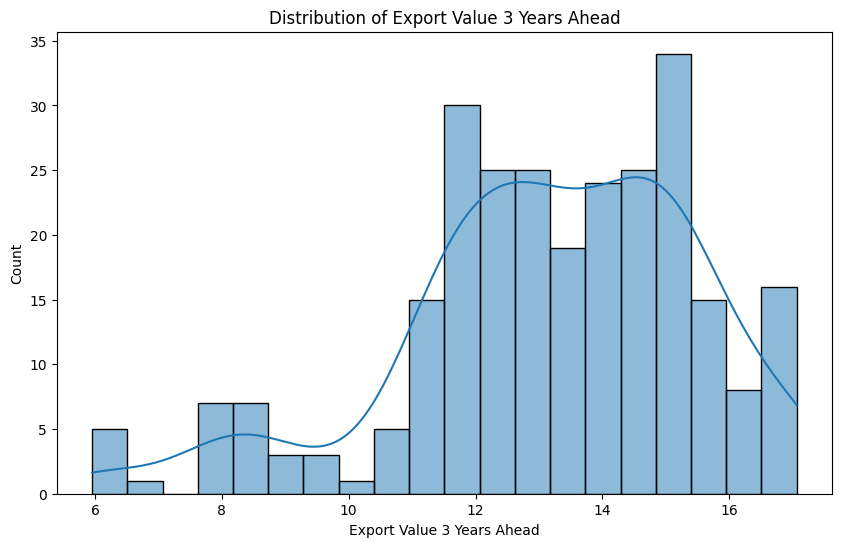

In [367]:
# Visualize the distribution of the target variable 'Export_Value_3_Years_Ahead'
plt.figure(figsize=(10, 6))
sns.histplot(data=skew_train_df, x='Export_Value_3_Years_Ahead', bins=20, kde=True)
plt.title('Distribution of Export Value 3 Years Ahead')
plt.xlabel('Export Value 3 Years Ahead')
plt.ylabel('Count')
plt.show()

### Scaling

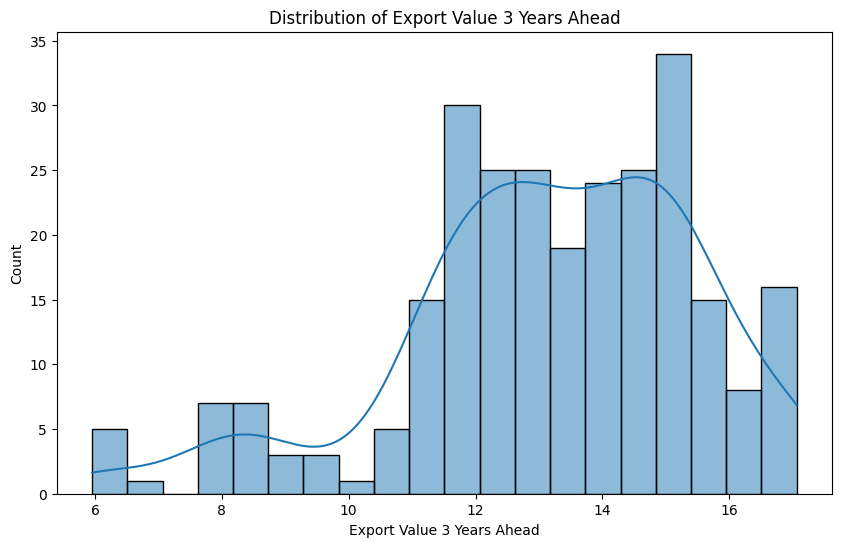

In [368]:
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Select features to scale (exclude the target variable 'Export_Value_3_Years_Ahead')
features_to_scale = [feature for feature in skew_train_df.columns if feature != 'Export_Value_3_Years_Ahead']

# Fit the scaler on the training data
scaler.fit(skew_train_df[features_to_scale])

# Apply the scaling transformation to the features of the training, validation, and test datasets
scaled_train_data = scaler.transform(skew_train_df[features_to_scale])
scaled_val_data = scaler.transform(skew_val_df[features_to_scale])
scaled_test_data = scaler.transform(skew_test_df[features_to_scale])

# Create DataFrames from the scaled arrays, using the original column names and indices
scaled_train_df = pd.DataFrame(scaled_train_data, columns=features_to_scale, index=skew_train_df.index)
scaled_val_df = pd.DataFrame(scaled_val_data, columns=features_to_scale, index=skew_val_df.index)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=features_to_scale, index=skew_test_df.index)

# Add the log-transformed target variable back to the scaled DataFrames
scaled_train_df['Export_Value_3_Years_Ahead'] = skew_train_df['Export_Value_3_Years_Ahead']
scaled_val_df['Export_Value_3_Years_Ahead'] = skew_val_df['Export_Value_3_Years_Ahead']
scaled_test_df['Export_Value_3_Years_Ahead'] = skew_test_df['Export_Value_3_Years_Ahead']

# Visualize the distribution of the target variable 'Export_Value_3_Years_Ahead'
plt.figure(figsize=(10, 6))
sns.histplot(data=scaled_train_df, x='Export_Value_3_Years_Ahead', bins=20, kde=True)
plt.title('Distribution of Export Value 3 Years Ahead')
plt.xlabel('Export Value 3 Years Ahead')
plt.ylabel('Count')
plt.show()

# Section 5: Building and evaluating a multilayer perceptron (MLP)

In [369]:
#number of features

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Define the model with L2 regularization
model = models.Sequential([
    layers.Dense(85, activation='relu', input_shape=(scaled_train_df.shape[1]-1,), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(85, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(85, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='relu')
])

# Compile the model with the custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(scaled_train_df.drop(columns=['Export_Value_3_Years_Ahead']),
                    scaled_train_df['Export_Value_3_Years_Ahead'],
                    epochs=10000,
                    batch_size=32,
                    validation_data=(scaled_val_df.drop(columns=['Export_Value_3_Years_Ahead']), scaled_val_df['Export_Value_3_Years_Ahead']),
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(scaled_test_df.drop(columns=['Export_Value_3_Years_Ahead']), scaled_test_df['Export_Value_3_Years_Ahead'], verbose=0)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Printout the weights of the model
for layer in model.layers:
    if layer.trainable:
        weights, biases = layer.get_weights()
        print(f'{layer.name} weights shape: {weights.shape}')
        print(f'{layer.name} biases shape: {biases.shape}')
        print(f'{layer.name} weights: {weights}')
        print(f'{layer.name} biases: {biases}')
        

Epoch 1/10000


/Users/pbson/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 178.8055 - mean_absolute_error: 13.0933 - val_loss: 182.4216 - val_mean_absolute_error: 13.3211
Epoch 2/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 184.1879 - mean_absolute_error: 13.3159 - val_loss: 181.6128 - val_mean_absolute_error: 13.2958
Epoch 3/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 177.9952 - mean_absolute_error: 13.0675 - val_loss: 180.5718 - val_mean_absolute_error: 13.2609
Epoch 4/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 177.1779 - mean_absolute_error: 13.0635 - val_loss: 178.3620 - val_mean_absolute_error: 13.1797
Epoch 5/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170.8760 - mean_absolute_error: 12.7905 - val_loss: 175.7258 - val_mean_absolute_error: 13.0809
Epoch 6/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171.1298 - mean_absolute_error: 12.8119 - val_loss: 172.9726 - val_mean_absolute_error: 12.9768
Epoch 7/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169.7224 - mean_absolute

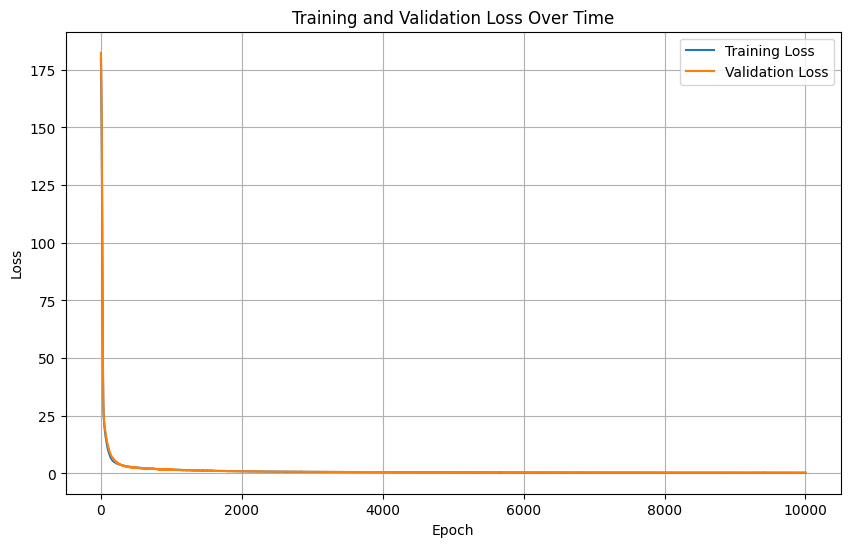

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepWARNING:tensorflow:5 out of the last 36 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2a4661dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [370]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Predictions
predictions = model.predict(test_df.drop(columns=['Export_Value_3_Years_Ahead']))

# Section 6: Performance of the model

In [371]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the transformed and scaled test set
predictions_log_scale = model.predict(scaled_test_df.drop(columns=['Export_Value_3_Years_Ahead'])).flatten()

# Apply the inverse transformation (expm1) to predictions and true labels
predictions = np.expm1(predictions_log_scale)
true_labels = np.expm1(scaled_test_df['Export_Value_3_Years_Ahead'])

# Calculate the percentage difference between predictions and true labels
percentage_difference = (np.abs(predictions - true_labels) / true_labels) * 100

# Create results DataFrame
results_df = pd.DataFrame({
    'True_Label': true_labels,
    'Prediction': predictions,
    'Percentage_Difference': percentage_difference
})

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


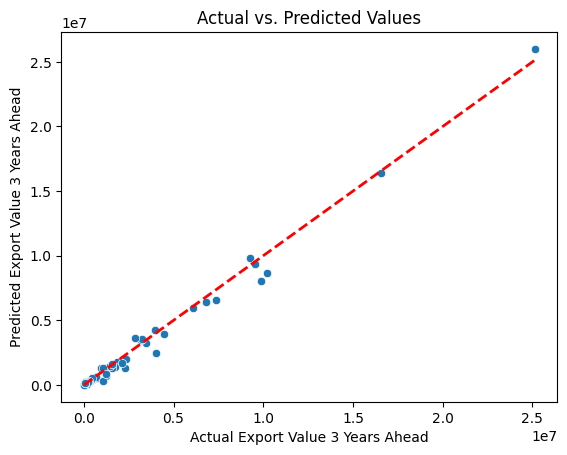

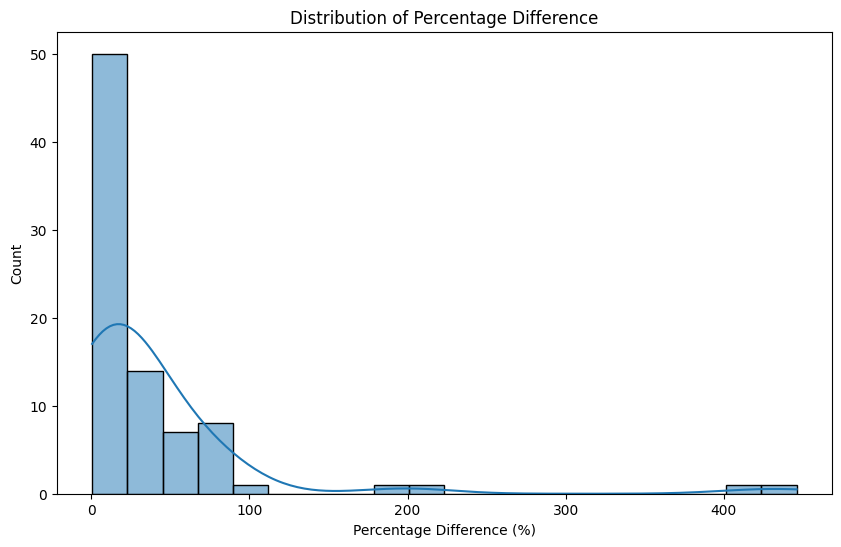

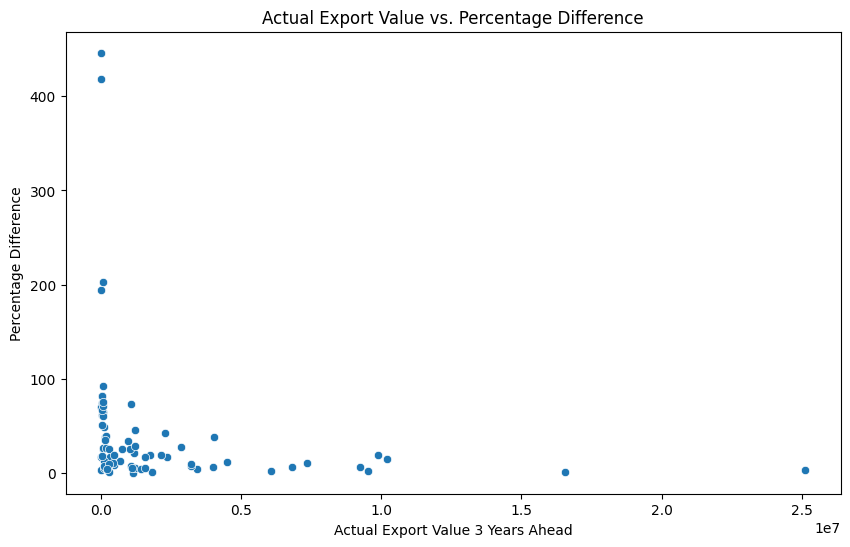

     True_Label     Prediction  Percentage_Difference
110     5192.87   28355.542969             446.047619
252      597.96    3098.794434             418.227713
28     70833.00  214543.359375             202.886168
396     4925.03   14509.202148             194.601295
176    59109.08  113979.820312              92.829630


In [374]:
#Plot the percentage difference
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='True_Label', y='Prediction', data=results_df)
plt.plot([results_df['True_Label'].min(), results_df['True_Label'].max()], [results_df['True_Label'].min(), results_df['True_Label'].max()], 'r--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual Export Value 3 Years Ahead')
plt.ylabel('Predicted Export Value 3 Years Ahead')
plt.title('Actual vs. Predicted Values')
plt.show()

# Plot the distribution of the percentage difference
plt.figure(figsize=(10, 6))
sns.histplot(percentage_difference, bins=20, kde=True)
plt.title('Distribution of Percentage Difference')
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Count')
plt.show()

#Plot the actual vs the percentage difference of each prediction, not the prediction vs the actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True_Label', y='Percentage_Difference', data=results_df)
plt.xlabel('Actual Export Value 3 Years Ahead')
plt.ylabel('Percentage Difference')
plt.title('Actual Export Value vs. Percentage Difference')
plt.show()

# Print the least accurate predictions
least_accurate = results_df.sort_values(by='Percentage_Difference', ascending=False)
print(least_accurate.head())

In [375]:
#show the mean squared error and mean absolute error
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the mean squared error
mse = mean_squared_error(true_labels, predictions)

# Calculate the mean absolute error
mae = mean_absolute_error(true_labels, predictions)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

Mean Squared Error: 170749417571.43
Mean Absolute Error: 209892.34


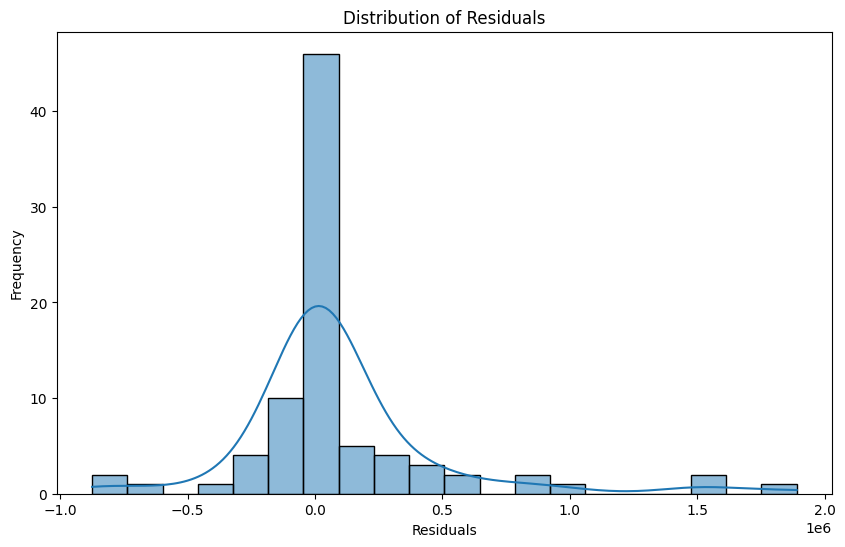

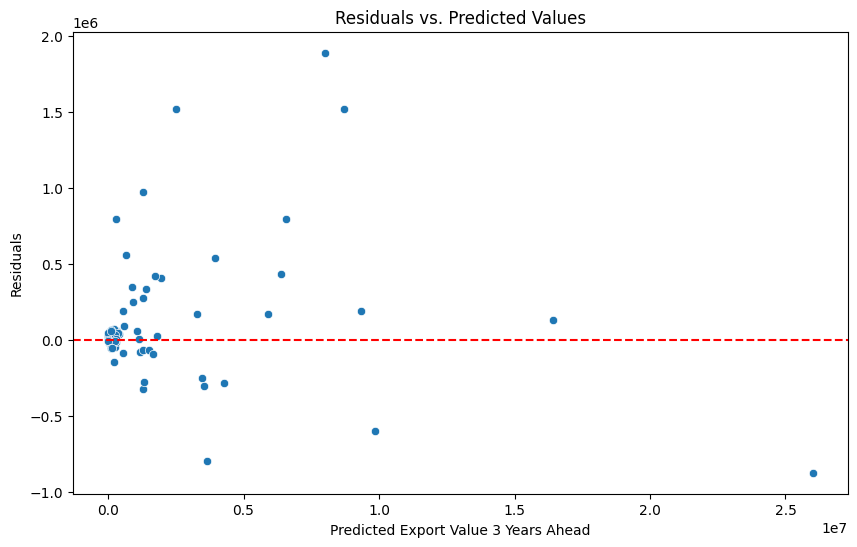

/Users/pbson/Library/Python/3.9/lib/python/site-packages/prettypandas/summarizer.py:215: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  self


,True_Label,Prediction,Percentage_Difference,Residuals
358,9895309.970000,8005660.000000,19.096420,1889649.970000
70,4019344.660000,2497198.500000,37.870506,1522146.160000
413,10213456.500000,8695508.000000,14.862241,1517948.500000
103,2275819.860000,1304324.750000,42.687698,971495.110000
207,25128922.460000,26003158.000000,3.479001,874235.540000


In [376]:
residuals = true_labels - predictions

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Export Value 3 Years Ahead')
plt.ylabel('Residuals')
plt.show()

# Add residuals to the results DataFrame
results_df['Residuals'] = residuals

# Sort by the absolute value of residuals to find the largest errors
largest_errors = results_df.abs().sort_values(by='Residuals', ascending=False)

# Display the cases with the largest errors
PrettyPandas(largest_errors.head())